In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Review

The first three steps in data science are to:
* find some data
* look at your data (summary statistics, visualizations)
* clean and normalize your data (drop columns, fill in missing / erroneous values, translate, scale, rotate)

Today we will keep working with the set of Craigslist listings for used cars.
* Where did it come from?
* What does it look like?
* What types of cleaning have I done to it and what types do I still ahve to do?

Now we will load this dataset.

In [2]:
# Load the data
# This dataset is the hyundai/kia subsample from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup

data = np.array(np.genfromtxt('data/vehiclesNumeric.csv', delimiter=',', skip_header=1, dtype=int, encoding='utf-8', usecols=[1,2]))  
print(data)

[[ 9988  2014]
 [ 5500  2010]
 [ 9500  2013]
 ...
 [11999  2014]
 [ 7999  2013]
 [10999  2014]]


Let's get some summary statistics so we can see what's going on.

In [3]:
def getSummaryStatistics(data):
    print("min, max, mean, std per variable")
    return pd.DataFrame([data.min(axis=0), data.max(axis=0), data.mean(axis=0), data.std(axis=0)])

def getShapeType(data):
    print("shape")
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))

min, max, mean, std per variable
              0            1
0      0.000000  1999.000000
1  55000.000000  2021.000000
2   7978.281507  2012.381887
3   5542.906703     3.997048
shape
((3158, 2), dtype('int64'))


## Let's review regression

Regression allows us to:
* determine the *nature* of a relationship between one (or more!) independent variables and a dependent variable
* determine the *strength* of the relationship

Regression *fits* a function to a dataset.

Regression is *not* the same as interpolation. Why not?

In order to define regression, we need three things. And they are?
* function (in this case, a line)
* a method for fitting the function to the data
* a measure of goodness of fit

## What kinds of functions can we fit? 

We are going to start with *linear regression*. What type of function do we fit when we do linear regression?

30723814.716510456


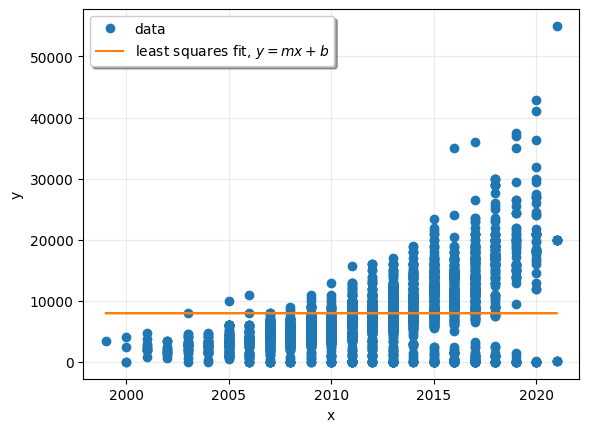

In [4]:
# multiply the xs by the m and add b
def linear_regression(x, m, b):
    return x*m + b

# Mean sum of squared errors; why squared?
def msse(y, yhat):
    r = (np.square(y - yhat)).mean()
    return r

def plotxyyhat(x, y, yhat):
    plt.plot(x, y, 'o', label='data')
    plt.plot(x, yhat, label='least squares fit, $y = mx + b$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

# x is model year
x = data[:, 1]

# y is price
y = data[:, 0]

# calculate yhat, using the mean as the intercept and the 0 as the slope
yhat = linear_regression(x, 0, y.mean())
print(msse(y, yhat))

plotxyyhat(x, y, yhat)

## What does it mean to *fit* a function? 

Now let's talk about methods for making the function "fit" the data. We know $x$, and we know $y$. We do *not* know the values for $b$ or $m$; that's what we need to figure out. 

The function "lstsq" in the scipy package's linalg (linear algebra) subpackage
fits a linear regression using least squares. It gives us predicted $y$ values $\hat{y}$ and residuals for each $\hat{y}$. Let's try it on our data.

use data to get c

use c and residues to fit to data nd get 

min, max, mean, std per variable
     0            1
0  1.0  1999.000000
1  1.0  2021.000000
2  1.0  2012.381887
3  0.0     3.997048
[-1.55686421e+06  7.77607125e+02]


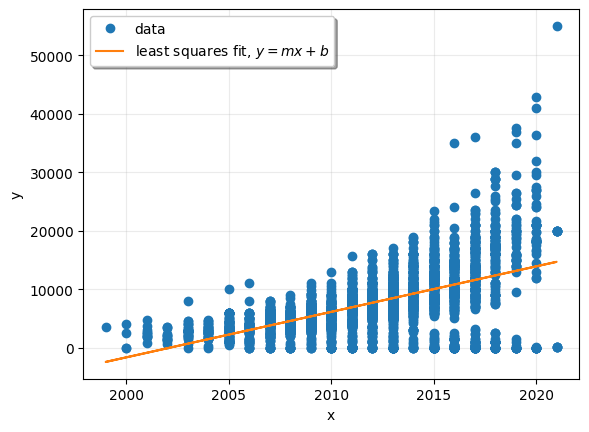

In [5]:
import scipy.linalg as sp_la

def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[:, independent]
 
    # We add a column of 1s for the intercept
    A = x[:, np.newaxis]**[0, 1]
    print(getSummaryStatistics(A))
 
    # This is the dependent variable 
    y = data[:, dependent]
 
    # This is the regression coefficients that were fit, plus some other results
    c, res, _, _ = sp_la.lstsq(A, y)

    return c, res

c, res = fit(data, 1, 0)
# this is b and m!
print(c)
yhat = linear_regression(data[:, 1], c[1], c[0])
plotxyyhat(data[:, 1], data[:, 0], yhat)



Let's figure out MSSE for this function (model)

In [6]:
print(msse(data[:, 0], yhat))


21063324.757039122


Well, that certainly fits the data better than our previous guess.

## And, this is a function we can use to predict the $y$ (calculate the $\hat{y}$) for new $x$s, so it's a *model*!

For example, my car was a 2016 Hyundai, so what should its Craigslist price be?

In [7]:
print(c[1]*2016+c[0])

10791.75174517301


*What about your Hyundais??*

Of course, this model is based on *historical* car prices, and what has happened over the past six months?

## How do we know how well our model works?

In order to see how well our model works, we could just calculate the MSSE on our data. But that won't tell us how well our model *generalizes* to data it hasn't seen before. In order to do that, we need a *held-out test set*. And then we would calculate how well the regression predictions matched the true prices for the held-out data. In particular, we would calculate $$R^2 = 1 - \frac{\sum_{i=1}^N (y_i - \hat{y})^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$$
The numerator there tells us the error of the model (vs just calculating the mean of the data) and the denominator tells us the error of the data vs the mean of the data. We use this instead of MSSE, because it tells us how well our model outperforms a really stupid model (just use the mean of the data).

In fact, the numerator is the residuals! So we can rewrite this as $$R^2 = 1 - \frac{r_i^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$$

Let's split our data into **train** and **test**. Let's make sure and sort by time first, because we don't want to let the future predict the past.

In [8]:
data = data[data[:, 1].argsort()]
print(getSummaryStatistics(data))
print(getShapeType(data))

(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)


min, max, mean, std per variable
              0            1
0      0.000000  1999.000000
1  55000.000000  2021.000000
2   7978.281507  2012.381887
3   5542.906703     3.997048
shape
((3158, 2), dtype('int64'))
(2526, 2) (632, 2)


Then, let's use the *train* data to fit the model. 

use train data to get c, res


calcualte yhat for trainiding data 

min, max, mean, std per variable
     0             1
0  1.0      0.000000
1  1.0  23995.000000
2  1.0   6870.788599
3  0.0   3935.935201
[-1.92458144e-13  1.00000000e+00] 1.6935310462551662e-21
(2526,)


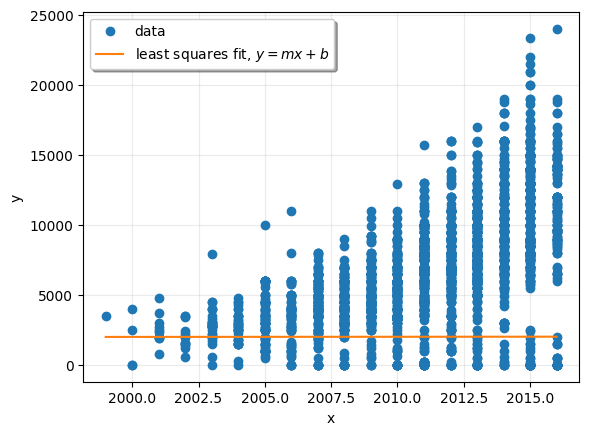

In [9]:
c, res = fit(train, 0, 0)
# this is b and m!
print(c, res)

yhat = linear_regression(train[:, 1], c[1], c[0])
print(yhat.shape)
plotxyyhat(train[:, 1], train[:, 0], yhat)


Then let's use the test data to evaluate our model:
* We will take the model we fit (the prediction function we fit) to our *training data*
* We will use it to predict values for the new data, the *test data*
* We will measure how well the model does at predicting

Just above when we fit the model, we calculated $$ A \cdot \vec{c} = \vec{\hat{y}} $$
and we knew $A$ and $\vec{y}$.

Now we know $A$ and $\vec{c}$ and we want to calculate $\vec{\hat{y}}$.


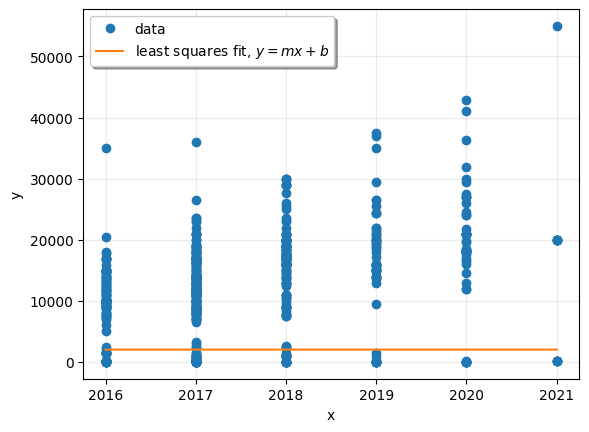

In [10]:
def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[:, independent]

    # We add a column of 1s for the intercept
    A = x[:, np.newaxis]**[0, 1]

    return np.dot(A, c)

yhat = predict(test, 1, c)
plotxyyhat(test[:, 1], test[:, 0], yhat)


Compare the *fit* on the test data to the *fit* on the training data. What do you think?

In [11]:
# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return 1 - (((y - yhat)**2).sum() / ((y - y.mean())**2).sum())

yhat = predict(train, 1, c)
print(rsquared(train[:, 0], yhat))
yhat = predict(test, 1, c)
print(rsquared(test[:, 0], yhat))

-1.5235185599510137
-1.6076438629070715


How does $R^2$ resemble $MSSE$, and how not? What does $R^2$ look like when the dependent variable is very highly correlated with the independent variable, for example they are the same? What does it look like when they are not at all correlated?

Let's come back to this notion of *correlation*. If two variables are highly *correlated* then a linear regression calculated using one of them as the independent variable and the other as the dependent variable will have *what size of* $R^2$? 

If two variables are highly correlated does this mean one *caused* the other? Why or why not?